# Import Module

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import NLTKWordTokenizer
from nltk.tag import pos_tag
import nltk
nltk.download('all')
import spacy
from math import sqrt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,roc_auc_score,accuracy_score,f1_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/meepoom/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/meepoom/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/meepoom/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/meepoom/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/meepoom/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading pa

# Load Data

In [2]:
%%time 
data_1 = pd.read_json("data//running.json")
data_1['subreddit'] = "running"

CPU times: user 47.7 ms, sys: 13.1 ms, total: 60.8 ms
Wall time: 63.8 ms


#### Subreddit Community : CampingandHiking

In [3]:
%%time 
data_2 = pd.read_json("data//CampingandHiking.json")
data_2['subreddit'] = "CampingandHiking"

CPU times: user 38.1 ms, sys: 5.71 ms, total: 43.8 ms
Wall time: 44.1 ms


## Data Prepare - sample_data

### Sample Data 1 - Community Running

In [4]:
## Select feature from main data and convect unix date to normal, and rename column name

#sample_data_1 = data_1[["title","selftext","subreddit"]]
#sample_data_1['date'] = pd.to_datetime(data_1['created_utc'],unit='s').dt.date

#sample_data_1.rename(columns = {'selftext':'text'}, inplace = True)
#sample_data_1.drop_duplicates('title')

In [5]:
sample_data_1 = data_1[["title","text","subreddit","date"]]

In [6]:
sample_data_2 = data_2[["title","text","subreddit","date"]]

## Create Train Data

### Combine two dataset

In [7]:
train_data = pd.concat([sample_data_1, sample_data_2], axis=0).reset_index(drop=True)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37849 entries, 0 to 37848
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      37849 non-null  object        
 1   text       26504 non-null  object        
 2   subreddit  37849 non-null  object        
 3   date       37849 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 1.2+ MB


### Drop Duplicate Title

In [9]:
# Remove duplicate title
train_data = train_data.drop_duplicates('title')
train_data = train_data.drop_duplicates('text')
print(f"Total title: {len(sample_data_1) - len(train_data)} duplicate , remain: {len(train_data)} titles.")

Total title: 10951 duplicate , remain: 7649 titles.


In [10]:
train_data.subreddit.value_counts()

subreddit
running             3837
CampingandHiking    3812
Name: count, dtype: int64

In [11]:
train_data['text'].value_counts()

text
[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

### Remove Null Value
There are 3 types of missing values:
1. null values
2. `[removed]`
3. `[deleted]`


In [12]:
train_data.isnull().sum()

title        0
text         1
subreddit    0
date         0
dtype: int64

In [13]:
train_data[train_data["text"].isnull() == True]

,title,text,subreddit,date
13,Resolution Run 2018. 12 rounds of the track to...,None,running,2018-01-02


In [14]:
train_data[train_data["text"] == "[removed]"]

,title,text,subreddit,date
0,Tendinosis finally healing,[removed],running,2018-01-02


In [15]:
train_data = train_data.replace({"[removed]": ""})
train_data = train_data.replace(np.nan, "")

### Create Target Column from Title & Text

In [16]:
train_data['target'] = train_data['title'] + ' '+ train_data['text']
train_data.head()

,title,text,subreddit,date,target
0,Tendinosis finally healing,,running,2018-01-02,Tendinosis finally healing
4,Cold running is..new and rough,It's been 6 years since I ran in ANY cold and ...,running,2018-01-02,Cold running is..new and rough It's been 6 yea...
8,Super Moronic Monday -- Your Tuesday Weekly St...,"It's Tuesday, which means it is time for Moron...",running,2018-01-02,Super Moronic Monday -- Your Tuesday Weekly St...
9,Flitch Way NYE Trail Marathon,[deleted],running,2018-01-02,Flitch Way NYE Trail Marathon [deleted]
13,Resolution Run 2018. 12 rounds of the track to...,,running,2018-01-02,Resolution Run 2018. 12 rounds of the track to...


### Remove None Word

In [17]:
def text_cleaning(text):
    punc = re.sub(r"[/%]", "", string.punctuation)                  # Remove Punctuation
    clean = "".join(l for l in text if l not in punc)               # Remove Punctuation
    
    text = bs(clean)
    clean = text.get_text(strip=True)
    clean = re.sub(r"(\\n)+", " ", clean)
    clean = re.sub(r"(\n)+", " ", clean)
    clean = re.sub(r"http\S+|www.\S+", "", clean)
    clean = clean.lower()
    return clean

In [18]:
train_data['target']=train_data['target'].apply(text_cleaning)

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_6495/4165698117.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = bs(clean)


In [19]:
train_data['subreddit'].unique()

array(['running', 'CampingandHiking'], dtype=object)

### Convert Subreddit target from Word to Number
* running = 0
* CampingandHiking = 1

In [20]:
train_data['subreddit'] = train_data['subreddit'].map({'running':int(0), 'CampingandHiking':int(1)})
train_data.head()

,title,text,subreddit,date,target
0,Tendinosis finally healing,,0,2018-01-02,tendinosis finally healing
4,Cold running is..new and rough,It's been 6 years since I ran in ANY cold and ...,0,2018-01-02,cold running isnew and rough its been 6 years ...
8,Super Moronic Monday -- Your Tuesday Weekly St...,"It's Tuesday, which means it is time for Moron...",0,2018-01-02,super moronic monday your tuesday weekly stup...
9,Flitch Way NYE Trail Marathon,[deleted],0,2018-01-02,flitch way nye trail marathon deleted
13,Resolution Run 2018. 12 rounds of the track to...,,0,2018-01-02,resolution run 2018 12 rounds of the track to ...


# NLP Process

## Lemmatizing,Tokenize & POS Tagging

<img src="/Users/meepoom/Library/CloudStorage/OneDrive-Personal/Data_Science/DSi03/Project_3/img/nltk_pos_tag.jpeg" alt="Drawing" style="width: 500px;"/>

- POS-tagger, processes a sequence of words, and attaches a part of speech tag to each word. To do this first we have to use tokenization concept (Tokenization is the process by dividing the quantity of text into smaller parts called tokens.)

In [21]:
# Sample
pos_tag(nltk.word_tokenize("John's big idea isn't all that bad."))

[('John', 'NNP'),
 ("'s", 'POS'),
 ('big', 'JJ'),
 ('idea', 'NN'),
 ('is', 'VBZ'),
 ("n't", 'RB'),
 ('all', 'PDT'),
 ('that', 'DT'),
 ('bad', 'JJ'),
 ('.', '.')]

In [22]:
%%time 
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemma(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 2.86 µs


## Stop Word

In [23]:
%%time 
nlp = spacy.load("en_core_web_sm")

def remove_stop_words(text_column):
    processed_texts = []

    for text in text_column:
        doc = nlp(text)
        filtered_text = ' '.join([token.text for token in doc if not token.is_stop])
        processed_texts.append(filtered_text)

    return processed_texts

CPU times: user 303 ms, sys: 14.5 ms, total: 317 ms
Wall time: 328 ms


In [24]:
%%time 
train_data['stop_word'] = remove_stop_words(train_data['target'])
train_data['ltp_word'] = train_data.stop_word.apply(lemma)

CPU times: user 5min 16s, sys: 9.45 s, total: 5min 26s
Wall time: 5min 28s


In [25]:
train_data.head()

,title,text,subreddit,date,target,stop_word,ltp_word
0,Tendinosis finally healing,,0,2018-01-02,tendinosis finally healing,tendinosis finally healing,"[tendinosis, finally, heal]"
4,Cold running is..new and rough,It's been 6 years since I ran in ANY cold and ...,0,2018-01-02,cold running isnew and rough its been 6 years ...,cold running isnew rough 6 years ran cold wet ...,"[cold, run, isnew, rough, 6, year, ran, cold, ..."
8,Super Moronic Monday -- Your Tuesday Weekly St...,"It's Tuesday, which means it is time for Moron...",0,2018-01-02,super moronic monday your tuesday weekly stup...,super moronic monday tuesday weekly stupid q...,"[super, moronic, monday, tuesday, weekly, stup..."
9,Flitch Way NYE Trail Marathon,[deleted],0,2018-01-02,flitch way nye trail marathon deleted,flitch way nye trail marathon deleted,"[flitch, way, nye, trail, marathon, delete]"
13,Resolution Run 2018. 12 rounds of the track to...,,0,2018-01-02,resolution run 2018 12 rounds of the track to ...,resolution run 2018 12 rounds track set baseli...,"[resolution, run, 2018, 12, round, track, set,..."


## Word Frequency

In [26]:
# Split 2 dataset for word frequency
data_run = train_data[train_data['subreddit'] == 0]
data_hike = train_data[train_data['subreddit'] == 1]

## Word Frequency
- Bigram
- Unigram
- Trigram

and Wordcloud

In [27]:
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

n_range = ()

def get_n_ngrams(c, n=None):
    stopwords = "english"
    vec = TfidfVectorizer(ngram_range=(n_range) ,stop_words = stopwords).fit(c)
    bag_of_words = vec.transform(c)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [28]:
# Create Unigram
n_range = (1,1)
run_top20_unigram = dict(get_n_ngrams([word for word in data_run['stop_word']],20))
hiking_top20_unigram = dict(get_n_ngrams([word for word in data_hike['stop_word']],20))

In [29]:
# Create Bigram
n_range = (2,2)
run_top20_bigram = dict(get_n_ngrams([word for word in data_run['stop_word']],20))
hiking_top20_bigram = dict(get_n_ngrams([word for word in data_hike['stop_word']],20))

In [30]:
# Create Trigram
n_range = (3,3)
run_top20_trigram = dict(get_n_ngrams([word for word in data_run['stop_word']],20))
hiking_top20_trigram = dict(get_n_ngrams([word for word in data_hike['stop_word']],20))

### Vizturize

In [120]:
def chart_top_n_grams(dict_1, dict_2, wspace):
    fig, axes = plt.subplots(1,2, figsize=(15,5));
    
    color_1 = cm.tab20(np.linspace(0, 1, 20))
    color_2 = cm.tab20b(np.linspace(0, 1, 20))
    
    # plot the first graph
    plt.subplot(1,2,1)
    uni_chart = plt.barh(range(len(dict_1)), dict_1.values(),align = 'center',color=color_1);
    plt.yticks(range(len(dict_1)),dict_1.keys(),fontsize=8);
    plt.gca().invert_yaxis() # reverse yaxis
    plt.title('Top 20 Unigram of Running' ,fontsize = 10)
    plt.xlabel('Frequency',fontsize = 8)
    
    # plot the second graph
    plt.subplot(1,2,2)
    bi_chart = plt.barh(range(len(dict_2)), dict_2.values(),align = 'center',color=color_2);
    plt.yticks(range(len(dict_2)),dict_2.keys(),fontsize=8);
    plt.gca().invert_yaxis()
    plt.title('Top 20 Bigram of Running',fontsize = 10)
    plt.xlabel('Frequency',fontsize = 8)

        
    plt.subplots_adjust(wspace = wspace,hspace = wspace)
    plt.show()

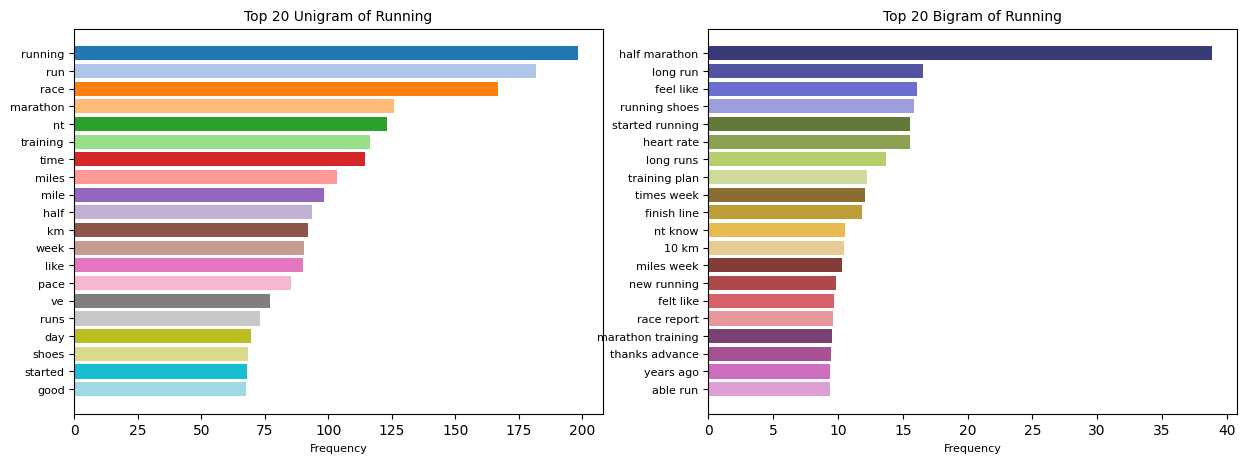

In [119]:
chart_top_n_grams(run_top20_unigram, run_top20_bigram, 0.2)

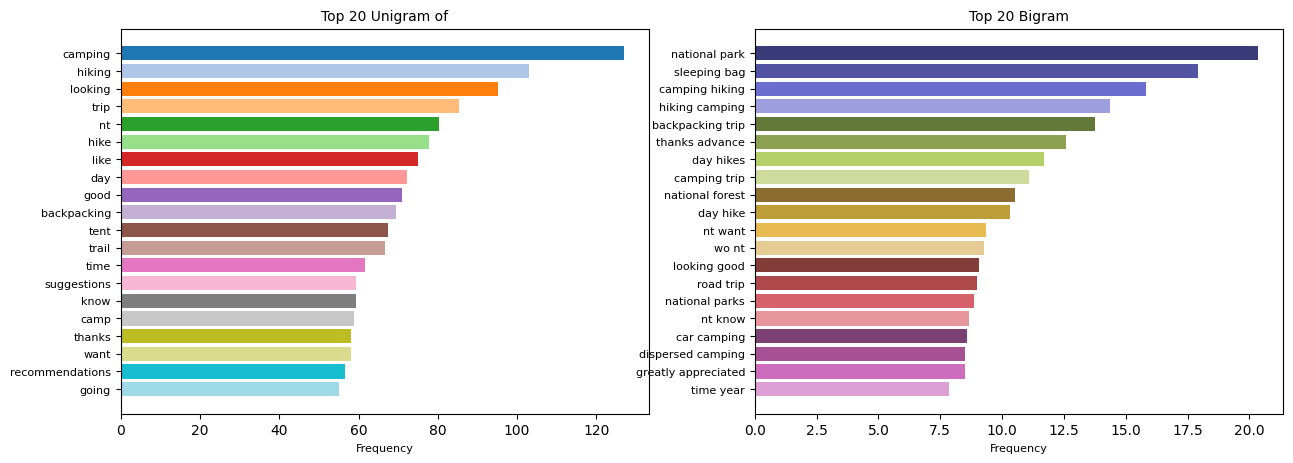

In [117]:
chart_top_n_grams(hiking_top20_unigram, hiking_top20_bigram, 0.2)

# Modeling

- Lofistic Regression with GridSearch
- KNN Neightbour
- Ramdom Forest
- SVM

Check class balance.

In [34]:
train_data.subreddit.value_counts()

subreddit
0    3837
1    3812
Name: count, dtype: int64

## Splitting Data

In [35]:
X = train_data.target
y = train_data.subreddit

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

### Pipeline

### Logistic Regression

##### CountVectorize

In [36]:
pipe_lr_cv = Pipeline(
    [('cv', CountVectorizer()), ("log", LogisticRegression(random_state=42))]
)

- List parameter

In [37]:
pipe_lr_cv.get_params()

{'memory': None,
 'steps': [('cv', CountVectorizer()),
  ('log', LogisticRegression(random_state=42))],
 'verbose': False,
 'cv': CountVectorizer(),
 'log': LogisticRegression(random_state=42),
 'cv__analyzer': 'word',
 'cv__binary': False,
 'cv__decode_error': 'strict',
 'cv__dtype': numpy.int64,
 'cv__encoding': 'utf-8',
 'cv__input': 'content',
 'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 1),
 'cv__preprocessor': None,
 'cv__stop_words': None,
 'cv__strip_accents': None,
 'cv__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cv__tokenizer': None,
 'cv__vocabulary': None,
 'log__C': 1.0,
 'log__class_weight': None,
 'log__dual': False,
 'log__fit_intercept': True,
 'log__intercept_scaling': 1,
 'log__l1_ratio': None,
 'log__max_iter': 100,
 'log__multi_class': 'auto',
 'log__n_jobs': None,
 'log__penalty': 'l2',
 'log__random_state': 42,
 'log__solver': 'lbfgs',
 'log__tol': 0.0001,
 'log__verbose': 0,
 'log__warm_start': Fals

- Set parameter

In [38]:
lr_cv_params = {
    'cv__max_features': [2000, 4000],
    'cv__min_df': [2, 3],
    'cv__ngram_range': [(1,2), (2,2)],
    'log__penalty': ['l2'],
    'log__C': np.linspace(0.01, 4.3, 15)
}

- GridSearch

In [39]:
lr_cv_gs = GridSearchCV(pipe_lr_cv, param_grid=lr_cv_params, cv=5, n_jobs=5, error_score='raise', verbose=1)

- Fit Model

In [40]:
%time 
lr_cv_gs.fit(X_train, y_train)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('log',
                                        LogisticRegression(random_state=42))]),
             n_jobs=5,
             param_grid={'cv__max_features': [2000, 4000], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 2), (2, 2)],
                         'log__C': array([0.01      , 0.31642857, 0.62285714, 0.92928571, 1.23571429,
       1.54214286, 1.84857143, 2.155     , 2.46142857, 2.76785714,
       3.07428571, 3.38071429, 3.68714286, 3.99357143, 4.3       ]),
                         'log__penalty': ['l2']},
             verbose=1)

- Result

In [41]:
print(lr_cv_gs.best_estimator_)

Pipeline(steps=[('cv',
                 CountVectorizer(max_features=4000, min_df=2,
                                 ngram_range=(1, 2))),
                ('log',
                 LogisticRegression(C=0.9292857142857143, random_state=42))])


In [42]:
print('Accuracy scores for train and test: ')
print(lr_cv_gs.score(X_train, y_train))
print(lr_cv_gs.score(X_test, y_test))

Accuracy scores for train and test: 
0.9997094712376525
0.9751633986928104


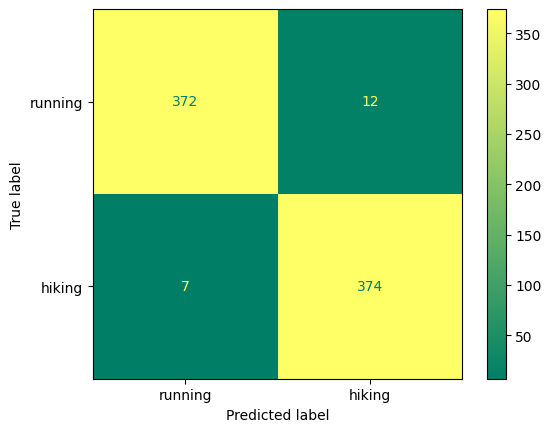

In [43]:
lr_cv_y_pred = lr_cv_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, lr_cv_y_pred, cmap='summer', display_labels=['running', 'hiking']);

- Score

In [44]:
# AUC Score
lr_cv_auc = roc_auc_score(y_test, lr_cv_gs.best_estimator_.predict_proba(X_test)[:,1])
lr_cv_auc

0.9968285214348207

In [45]:
y_pred_lr_cv_train =  lr_cv_gs.predict(X_train)
y_pred_lr_cv_test = lr_cv_gs.predict(X_test)

# Accuracy and F1 Score
print("---Training Set---")
print('Logistic Regression with Accuracy:', accuracy_score(y_train, y_pred_lr_cv_train))
print('Logistic Regression with F1-Score:', f1_score(y_train, y_pred_lr_cv_train))
print('\n')
print("---Test Set---")
print('Logistic Regression with Accuracy:', accuracy_score(y_test, y_pred_lr_cv_test))
print('Logistic Regression with F1-Score:', f1_score(y_test, y_pred_lr_cv_test))

---Training Set---
Logistic Regression with Accuracy: 0.9997094712376525
Logistic Regression with F1-Score: 0.9997086247086248


---Test Set---
Logistic Regression with Accuracy: 0.9751633986928104
Logistic Regression with F1-Score: 0.9752281616688396


##### TD-IDF

In [46]:
pipe_lr_tf = Pipeline(
    [('tfid', TfidfVectorizer()), ("log", LogisticRegression(solver='liblinear',random_state=42))]
)

- List parameter

In [47]:
pipe_lr_tf.get_params()

{'memory': None,
 'steps': [('tfid', TfidfVectorizer()),
  ('log', LogisticRegression(random_state=42, solver='liblinear'))],
 'verbose': False,
 'tfid': TfidfVectorizer(),
 'log': LogisticRegression(random_state=42, solver='liblinear'),
 'tfid__analyzer': 'word',
 'tfid__binary': False,
 'tfid__decode_error': 'strict',
 'tfid__dtype': numpy.float64,
 'tfid__encoding': 'utf-8',
 'tfid__input': 'content',
 'tfid__lowercase': True,
 'tfid__max_df': 1.0,
 'tfid__max_features': None,
 'tfid__min_df': 1,
 'tfid__ngram_range': (1, 1),
 'tfid__norm': 'l2',
 'tfid__preprocessor': None,
 'tfid__smooth_idf': True,
 'tfid__stop_words': None,
 'tfid__strip_accents': None,
 'tfid__sublinear_tf': False,
 'tfid__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfid__tokenizer': None,
 'tfid__use_idf': True,
 'tfid__vocabulary': None,
 'log__C': 1.0,
 'log__class_weight': None,
 'log__dual': False,
 'log__fit_intercept': True,
 'log__intercept_scaling': 1,
 'log__l1_ratio': None,
 'log__max_iter': 100,
 'log__m

- Set parameter

In [48]:
lr_tf_params = {
    'tfid__max_features': [2000, 4000],
    'tfid__min_df': [2, 3],
    'tfid__ngram_range': [(1,2), (2,2)],
    'log__penalty': ['l2'],
    'log__C': np.linspace(0.01, 4.3, 15)
}

- GridSearch

In [49]:
lr_tf_gs = GridSearchCV(pipe_lr_tf, param_grid=lr_tf_params,cv=5, n_jobs=5, error_score='raise', verbose=1)

- Fit Model

In [50]:
%time 
lr_tf_gs.fit(X_train, y_train)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfid', TfidfVectorizer()),
                                       ('log',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=5,
             param_grid={'log__C': array([0.01      , 0.31642857, 0.62285714, 0.92928571, 1.23571429,
       1.54214286, 1.84857143, 2.155     , 2.46142857, 2.76785714,
       3.07428571, 3.38071429, 3.68714286, 3.99357143, 4.3       ]),
                         'log__penalty': ['l2'],
                         'tfid__max_features': [2000, 4000],
                         'tfid__min_df': [2, 3],
                         'tfid__ngram_range': [(1, 2), (2, 2)]},
             verbose=1)

- Result

In [51]:
print(lr_tf_gs.best_estimator_)

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_features=4000, min_df=3,
                                 ngram_range=(1, 2))),
                ('log',
                 LogisticRegression(C=4.3, random_state=42,
                                    solver='liblinear'))])


In [52]:
print('Accuracy scores for train and test: ')
print(lr_tf_gs.score(X_train, y_train))
print(lr_tf_gs.score(X_test, y_test))

Accuracy scores for train and test: 
0.9973852411388727
0.9777777777777777


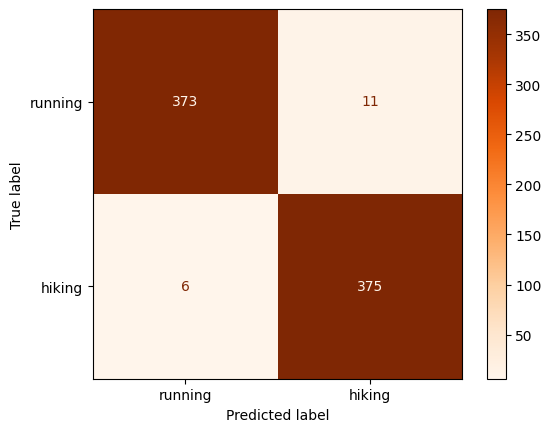

In [53]:
lr_tf_y_pred = lr_tf_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, lr_tf_y_pred, cmap='Oranges', display_labels=['running', 'hiking']);

- Score

In [54]:
# AUC Score
lr_tf_auc = roc_auc_score(y_test, lr_tf_gs.best_estimator_.predict_proba(X_test)[:,1])
lr_tf_auc

0.9981681977252843

In [55]:
y_pred_lr_tf_train =  lr_tf_gs.predict(X_train)
y_pred_lr_tf_test = lr_tf_gs.predict(X_test)

# Accuracy and F1 Score
print("---Training Set---")
print('Logistic Regression with Accuracy:', accuracy_score(y_train, y_pred_lr_tf_train))
print('Logistic Regression with F1-Score:', f1_score(y_train, y_pred_lr_tf_train))
print('\n')
print("---Test Set---")
print('Logistic Regression with Accuracy:', accuracy_score(y_test, y_pred_lr_tf_test))
print('Logistic Regression with F1-Score:', f1_score(y_test, y_pred_lr_tf_test))

---Training Set---
Logistic Regression with Accuracy: 0.9973852411388727
Logistic Regression with F1-Score: 0.9973799126637555


---Test Set---
Logistic Regression with Accuracy: 0.9777777777777777
Logistic Regression with F1-Score: 0.9778357235984355


### KNN Classification

##### CountVectorize

In [56]:
pipe_knn_cv = Pipeline(
    [('cv', CountVectorizer()), ("knn", KNeighborsClassifier())]
)

- List parameter

In [57]:
pipe_knn_cv.get_params()

{'memory': None,
 'steps': [('cv', CountVectorizer()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'cv': CountVectorizer(),
 'knn': KNeighborsClassifier(),
 'cv__analyzer': 'word',
 'cv__binary': False,
 'cv__decode_error': 'strict',
 'cv__dtype': numpy.int64,
 'cv__encoding': 'utf-8',
 'cv__input': 'content',
 'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 1),
 'cv__preprocessor': None,
 'cv__stop_words': None,
 'cv__strip_accents': None,
 'cv__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cv__tokenizer': None,
 'cv__vocabulary': None,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

- Set parameter

In [61]:
knn_cv_params = {
    'cv__max_features': [2000, 4000],
    'cv__min_df': [2, 3],
    'cv__ngram_range': [(1,2), (2,2)],
    #'knn__metric': ['minkowski', 'euclidean'],
    #'knn__n_neighbors': np.arange(5, 12, 2),
    #'knn__weights': ['uniform', 'distance']
}

- GridSearch

In [62]:
knn_cv_gs = GridSearchCV(pipe_knn_cv, param_grid=knn_cv_params, cv=5, n_jobs=2, error_score='raise', verbose=1)

- Fit Model

In [63]:
%time 
knn_cv_gs.fit(X_train, y_train)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 1.67 µs
Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=2,
             param_grid={'cv__max_features': [2000, 4000], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 2), (2, 2)]},
             verbose=1)

- Result

In [64]:
print(knn_cv_gs.best_estimator_)

Pipeline(steps=[('cv',
                 CountVectorizer(max_features=2000, min_df=3,
                                 ngram_range=(1, 2))),
                ('knn', KNeighborsClassifier())])


In [65]:
print('Accuracy scores for train and test: ')
print(knn_cv_gs.score(X_train, y_train))
print(knn_cv_gs.score(X_test, y_test))

Accuracy scores for train and test: 
0.8718768158047647
0.8091503267973856


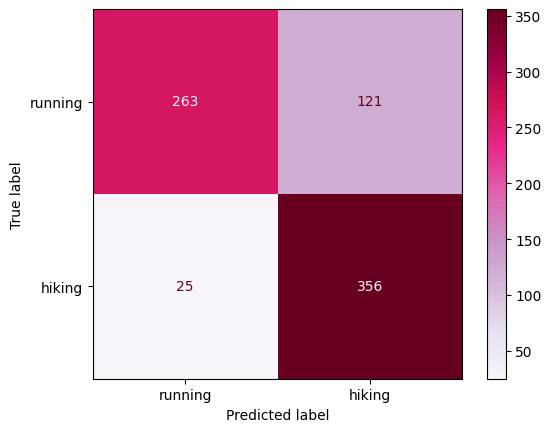

In [66]:
y_pred = knn_cv_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='PuRd', display_labels=['running', 'hiking']);

- Score

In [67]:
# AUC Score
knn_cv_auc = roc_auc_score(y_test, knn_cv_gs.best_estimator_.predict_proba(X_test)[:,1])
knn_cv_auc

0.8850817475940508

In [68]:
y_pred_knn_cv_train =  knn_cv_gs.predict(X_train)
y_pred_knn_cv_test = knn_cv_gs.predict(X_test)

# Accuracy and F1 Score
print("---Training Set---")
print('KNN Nightbour with Accuracy:', accuracy_score(y_train, y_pred_knn_cv_train))
print('KNN Nightbour with F1-Score:', f1_score(y_train, y_pred_knn_cv_train))
print('\n')
print("---Test Set---")
print('KNN Nightbour with Accuracy:', accuracy_score(y_test, y_pred_knn_cv_test))
print('KNN Nightbour with F1-Score:', f1_score(y_test, y_pred_knn_cv_test))

---Training Set---
KNN Nightbour with Accuracy: 0.8718768158047647
KNN Nightbour with F1-Score: 0.8819909017928821


---Test Set---
KNN Nightbour with Accuracy: 0.8091503267973856
KNN Nightbour with F1-Score: 0.8298368298368298


#### TF-IDF

In [69]:
pipe_knn_tf = Pipeline(
    [('cv', TfidfVectorizer()), ("knn", KNeighborsClassifier())]
)

- List parameter

In [70]:
pipe_knn_tf.get_params()

{'memory': None,
 'steps': [('cv', TfidfVectorizer()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'cv': TfidfVectorizer(),
 'knn': KNeighborsClassifier(),
 'cv__analyzer': 'word',
 'cv__binary': False,
 'cv__decode_error': 'strict',
 'cv__dtype': numpy.float64,
 'cv__encoding': 'utf-8',
 'cv__input': 'content',
 'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 1),
 'cv__norm': 'l2',
 'cv__preprocessor': None,
 'cv__smooth_idf': True,
 'cv__stop_words': None,
 'cv__strip_accents': None,
 'cv__sublinear_tf': False,
 'cv__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cv__tokenizer': None,
 'cv__use_idf': True,
 'cv__vocabulary': None,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

- Set parameter

In [71]:
knn_tf_params = {
    'cv__max_features': [2000, 4000],
    'cv__min_df': [2, 3],
    'cv__ngram_range': [(1,2), (2,2)],
    #'knn__metric': ['minkowski', 'euclidean'],
    #'knn__n_neighbors': np.arange(5, 12, 2),
    #'knn__weights': ['uniform', 'distance']
}

- GridSearch

In [72]:
knn_tf_gs = GridSearchCV(pipe_knn_tf, param_grid=knn_tf_params,cv=5, n_jobs=5, error_score='raise', verbose=1)

- Fit Model

In [73]:
%time 
knn_tf_gs.fit(X_train, y_train)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.15 µs
Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('cv', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=5,
             param_grid={'cv__max_features': [2000, 4000], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 2), (2, 2)]},
             verbose=1)

In [74]:
print(knn_tf_gs.best_estimator_)

Pipeline(steps=[('cv',
                 TfidfVectorizer(max_features=4000, min_df=3,
                                 ngram_range=(1, 2))),
                ('knn', KNeighborsClassifier())])


- Result

In [75]:
print('Accuracy scores for train and test: ')
print(knn_tf_gs.score(X_train, y_train))
print(knn_tf_gs.score(X_test, y_test))

Accuracy scores for train and test: 
0.9365194654270773
0.8901960784313725


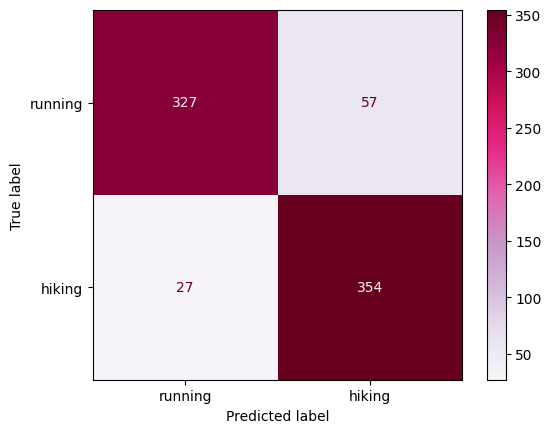

In [76]:
y_pred = knn_tf_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='PuRd', display_labels=['running', 'hiking']);

- Score

In [77]:
# AUC Score
knn_tf_auc = roc_auc_score(y_test, knn_tf_gs.best_estimator_.predict_proba(X_test)[:,1])
knn_tf_auc

0.9479508420822398

In [78]:
y_pred_knn_tf_train =  knn_tf_gs.predict(X_train)
y_pred_knn_tf_test = knn_tf_gs.predict(X_test)

# Accuracy and F1 Score
print("---Training Set---")
print('KNN Nightbour with Accuracy:', accuracy_score(y_train, y_pred_knn_tf_train))
print('KNN Nightbour with F1-Score:', f1_score(y_train, y_pred_knn_tf_train))
print('\n')
print("---Test Set---")
print('KNN Nightbour with Accuracy:', accuracy_score(y_test, y_pred_knn_tf_test))
print('KNN Nightbour with F1-Score:', f1_score(y_test, y_pred_knn_tf_test))

---Training Set---
KNN Nightbour with Accuracy: 0.9365194654270773
KNN Nightbour with F1-Score: 0.9400630914826498


---Test Set---
KNN Nightbour with Accuracy: 0.8901960784313725
KNN Nightbour with F1-Score: 0.8939393939393939


### Random Forest

##### CountVectorize

In [80]:
pipe_rf_cv = Pipeline(
    [('cv', CountVectorizer()), ("rf", RandomForestClassifier())]
)

- List parameter

In [81]:
pipe_rf_cv.get_params()

{'memory': None,
 'steps': [('cv', CountVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'cv': CountVectorizer(),
 'rf': RandomForestClassifier(),
 'cv__analyzer': 'word',
 'cv__binary': False,
 'cv__decode_error': 'strict',
 'cv__dtype': numpy.int64,
 'cv__encoding': 'utf-8',
 'cv__input': 'content',
 'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 1),
 'cv__preprocessor': None,
 'cv__stop_words': None,
 'cv__strip_accents': None,
 'cv__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cv__tokenizer': None,
 'cv__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 '

- Set parameter

In [89]:
rf_cv_params = {
    'cv__max_features': [2000, 4000],
    'cv__min_df': [2, 3],
    'cv__ngram_range': [(1,2), (2,2)],
    'rf__ccp_alpha': [0,1]
}

- GridSearch

In [90]:
rf_cv_gs = GridSearchCV(pipe_rf_cv, param_grid=rf_cv_params,cv=5, n_jobs=5, error_score='raise', verbose=1)


- Fit Model

In [91]:
%time 
rf_cv_gs.fit(X_train, y_train)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.15 µs
Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'cv__max_features': [2000, 4000], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 2), (2, 2)],
                         'rf__ccp_alpha': [0, 1]},
             verbose=1)

In [92]:
print(rf_cv_gs.best_estimator_)

Pipeline(steps=[('cv',
                 CountVectorizer(max_features=4000, min_df=3,
                                 ngram_range=(1, 2))),
                ('rf', RandomForestClassifier(ccp_alpha=0))])


- Result

In [93]:
print('Accuracy scores for train and test: ')
print(rf_cv_gs.score(X_train, y_train))
print(rf_cv_gs.score(X_test, y_test))

Accuracy scores for train and test: 
1.0
0.9790849673202614


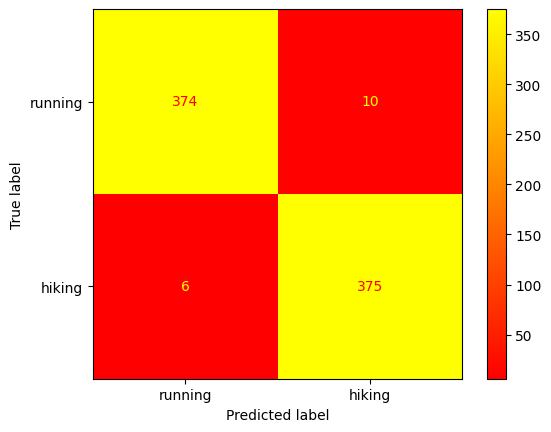

In [95]:
y_pred = rf_cv_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='autumn', display_labels=['running', 'hiking']);

- Score

In [96]:
# AUC Score
rf_cv_auc = roc_auc_score(y_test, rf_cv_gs.best_estimator_.predict_proba(X_test)[:,1])
rf_cv_auc

0.996261209536308

In [115]:
y_pred_rf_cv_train =  rf_cv_gs.predict(X_train)
y_pred_rf_cv_test = rf_cv_gs.predict(X_test)

# Accuracy and F1 Score
print("---Training Set---")
print('Random Forest with Accuracy:', accuracy_score(y_train, y_pred_rf_cv_train))
print('Random Forest with F1-Score:', f1_score(y_train, y_pred_rf_cv_train))
print('\n')
print("---Test Set---")
print('Random Forest with Accuracy:', accuracy_score(y_test, y_pred_rf_cv_test))
print('Random Forest with F1-Score:', f1_score(y_test, y_pred_rf_cv_test))

---Training Set---
Random Forest with Accuracy: 1.0
Random Forest with F1-Score: 1.0


---Test Set---
Random Forest with Accuracy: 0.9790849673202614
Random Forest with F1-Score: 0.97911227154047


##### TF-IDF (2 Sub-Model - Predict [Unigram & Bigram] and [Only Bigram])

In [98]:
pipe_rf_tf = Pipeline(
    [('cv', TfidfVectorizer()), ("rf", RandomForestClassifier())]
)

- List parameter

In [99]:
pipe_rf_tf.get_params()

{'memory': None,
 'steps': [('cv', TfidfVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'cv': TfidfVectorizer(),
 'rf': RandomForestClassifier(),
 'cv__analyzer': 'word',
 'cv__binary': False,
 'cv__decode_error': 'strict',
 'cv__dtype': numpy.float64,
 'cv__encoding': 'utf-8',
 'cv__input': 'content',
 'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__max_features': None,
 'cv__min_df': 1,
 'cv__ngram_range': (1, 1),
 'cv__norm': 'l2',
 'cv__preprocessor': None,
 'cv__smooth_idf': True,
 'cv__stop_words': None,
 'cv__strip_accents': None,
 'cv__sublinear_tf': False,
 'cv__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cv__tokenizer': None,
 'cv__use_idf': True,
 'cv__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_sp

- Set parameter

In [101]:
rf_tf_params = {
    'cv__max_features': [2000, 4000],
    'cv__min_df': [2, 3],
    'cv__ngram_range': [(1,2), (2,2)],
    'rf__ccp_alpha': [0,1]
}

In [139]:
# Rain Forest with TD-IDF

rf_tf_params_bigram = {
    'cv__max_features': [2000, 4000],
    'cv__min_df': [2, 3],
    'cv__ngram_range': [(2,2), (2,2)],
    'rf__ccp_alpha': [0,1]
}

In [140]:
# Rain Forest with TD-IDF
rf_tf_gs_bigram = GridSearchCV(pipe_rf_tf, param_grid=rf_tf_params_bigram,cv=5, n_jobs=5, error_score='raise', verbose=1)

In [141]:
# Rain Forest with TD-IDF
%time 
rf_tf_gs_bigram.fit(X_train, y_train)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.15 µs
Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('cv', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'cv__max_features': [2000, 4000], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(2, 2), (2, 2)],
                         'rf__ccp_alpha': [0, 1]},
             verbose=1)

In [142]:
# Rain Forest with TD-IDF
print('Accuracy scores for train and test: ')
print(rf_tf_gs_bigram.score(X_train, y_train))
print(rf_tf_gs_bigram.score(X_test, y_test))

Accuracy scores for train and test: 
0.9984020918070889
0.9215686274509803


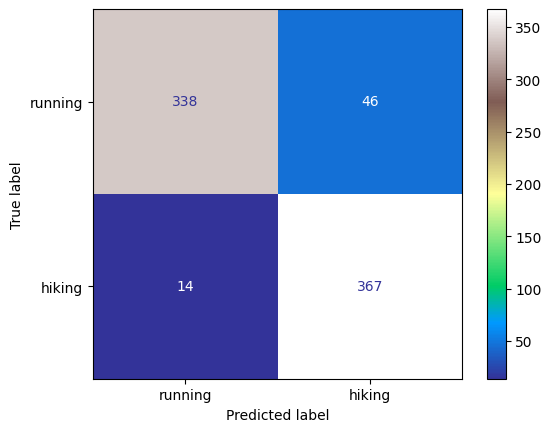

In [143]:
# Rain Forest with TD-IDF
y_pred = rf_tf_gs_bigram.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='terrain', display_labels=['running', 'hiking']);

In [148]:
y_pred_rf_tf_train_bi =  rf_tf_gs_bigram.predict(X_train)
y_pred_rf_tf_test_bi = rf_tf_gs_bigram.predict(X_test)

# Accuracy and F1 Score
print("---Training Set---")
print('andom Forest with Accuracy:', accuracy_score(y_train, y_pred_rf_tf_train_bi))
print('andom Forest with F1-Score:', f1_score(y_train, y_pred_rf_tf_train_bi))
print('\n')
print("---Test Set---")
print('Random Forest with Accuracy:', accuracy_score(y_test, y_pred_rf_tf_test_bi))
print('andom Forest with F1-Score:', f1_score(y_test, y_pred_rf_tf_test_bi))

---Training Set---
andom Forest with Accuracy: 0.9984020918070889
andom Forest with F1-Score: 0.9983995344100103


---Test Set---
Random Forest with Accuracy: 0.9215686274509803
andom Forest with F1-Score: 0.924433249370277


- GridSearch

In [102]:
rf_tf_gs = GridSearchCV(pipe_rf_tf, param_grid=rf_tf_params,cv=5, n_jobs=5, error_score='raise', verbose=1)

- Fit Model

In [103]:
%time 
rf_tf_gs.fit(X_train, y_train)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 1.91 µs
Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('cv', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'cv__max_features': [2000, 4000], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 2), (2, 2)],
                         'rf__ccp_alpha': [0, 1]},
             verbose=1)

In [104]:
print(rf_tf_gs.best_estimator_)

Pipeline(steps=[('cv',
                 TfidfVectorizer(max_features=4000, min_df=3,
                                 ngram_range=(1, 2))),
                ('rf', RandomForestClassifier(ccp_alpha=0))])


- Result

In [105]:
print('Accuracy scores for train and test: ')
print(rf_tf_gs.score(X_train, y_train))
print(rf_tf_gs.score(X_test, y_test))

Accuracy scores for train and test: 
1.0
0.9830065359477124


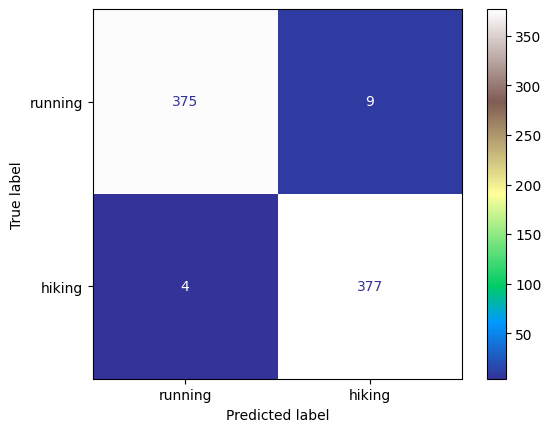

In [111]:
y_pred = rf_tf_gs.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='terrain', display_labels=['running', 'hiking']);

- Score

In [112]:
# AUC Score
rf_tf_auc = roc_auc_score(y_test, rf_tf_gs.best_estimator_.predict_proba(X_test)[:,1])
rf_tf_auc

0.9966508092738408

In [114]:
y_pred_rf_tf_train =  rf_tf_gs.predict(X_train)
y_pred_rf_tf_test = rf_tf_gs.predict(X_test)

# Accuracy and F1 Score
print("---Training Set---")
print('andom Forest with Accuracy:', accuracy_score(y_train, y_pred_rf_tf_train))
print('andom Forest with F1-Score:', f1_score(y_train, y_pred_rf_tf_train))
print('\n')
print("---Test Set---")
print('Random Forest with Accuracy:', accuracy_score(y_test, y_pred_rf_tf_test))
print('andom Forest with F1-Score:', f1_score(y_test, y_pred_rf_tf_test))

---Training Set---
andom Forest with Accuracy: 1.0
andom Forest with F1-Score: 1.0


---Test Set---
Random Forest with Accuracy: 0.9830065359477124
andom Forest with F1-Score: 0.983050847457627


## Model Scoring Compare

| Modeling | Vectorize | Accuracy | F1 Score |
|----------|-----------|----------|----------|
| Logistic Regression | CountVectorize | 0.996 | 0.975 |
| Logistic Regression | TF-IDF | 0.998 | 0.977 |
| KNN Classification | CountVectorize | 0.906 | 0.833 |
| KNN Classification | TF-IDF | 0.947 | 0.893 |
| Random Forest | CountVectorize | 0.996 | 0.979 |
| Random Forest | TF-IDF | 0.996 | 0.983 |

## Select Modeling : Random Forest (CountVectorize)